perhaps add more graphs if can get time to.

In [1]:
# importing necessary packages

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import cross_validation, tree, metrics, ensemble

%matplotlib inline

In [2]:
# reading in datasets

county_facts = pd.read_csv("../datasets/2016-us-election/county_facts.csv")
county_facts_dictionary = pd.read_csv("../datasets/2016-us-election/county_facts_dictionary.csv")
results = pd.read_csv('../datasets/2016-us-election/primary_results.csv')

In [3]:
county_facts_dictionary[:10] # a dictionary of all column headers

,column_name,description
0,PST045214,"Population, 2014 estimate"
1,PST040210,"Population, 2010 (April 1) estimates base"
2,PST120214,"Population, percent change - April 1, 2010 to ..."
3,POP010210,"Population, 2010"
4,AGE135214,"Persons under 5 years, percent, 2014"
5,AGE295214,"Persons under 18 years, percent, 2014"
6,AGE775214,"Persons 65 years and over, percent, 2014"
7,SEX255214,"Female persons, percent, 2014"
8,RHI125214,"White alone, percent, 2014"
9,RHI225214,"Black or African American alone, percent, 2014"


In [4]:
results[['fips', 'state_abbreviation', 'candidate', 'votes']].head()

,fips,state_abbreviation,candidate,votes
0,1001.0,AL,Bernie Sanders,544
1,1001.0,AL,Hillary Clinton,2387
2,1003.0,AL,Bernie Sanders,2694
3,1003.0,AL,Hillary Clinton,5290
4,1005.0,AL,Bernie Sanders,222


In [5]:
results[['fips', 'candidate', 'state_abbreviation', 'votes']].head()

,fips,candidate,state_abbreviation,votes
0,1001.0,Bernie Sanders,AL,544
1,1001.0,Hillary Clinton,AL,2387
2,1003.0,Bernie Sanders,AL,2694
3,1003.0,Hillary Clinton,AL,5290
4,1005.0,Bernie Sanders,AL,222


In [6]:
county_facts = county_facts.rename(columns={ # renaming columns for ease of reference/use
        'PST045214': 'pop_2014_est', 'PST040210': 'pop_2010_est', 'PST120214': 'pop_chg', 'POP010210': 'pop_2010',
        'AGE135214': 'under_5_pct', 'AGE295214': 'under_18_pct', 'AGE775214': 'above_64_pct', 'SEX255214': 'female_pct',
        'RHI125214': 'white', 'RHI1225214': 'black', 'RHI325214': 'native', 'RHI425214': 'asian', 'RHI525214': 'pacific',
        'RHI625214': 'multi', 'RHI725214': 'hispanic', 'RHI825214': 'white_nonhisp', 'POP645213': 'same_house_1+',
        'POP645213': 'foreign_born_09-13', 'POP815213': 'nonenglish_home', 'EDU635213': 'highschool',
        'EDU685213': 'bachelors', 'VET605213': 'veterans_09-13', 'HSG010214': 'housing_units', 'HSG445213': 'home_rate',
        'HSD310213': 'household_size', 'INC910213': 'percap_income_1yr', 'INC110213': 'median_income',
        'PVY020213': 'pct_below_poverty', 'BZA010213': 'priv_nonfarm', 'SBO001207': 'num_firms',
        'SBO315207': 'black_firm_pct', 'SBO115207': 'native_firm_pct', 'SBO215207': 'asian_firm_pct',
        'SBO515207': 'pacific_firm_pct', 'SBO415207': 'hispanic_firm_pct', 'SBO015207': 'female_firm_pct',
        'MAN450207': 'mfct_shipments_07', 'RTN130207': 'rsales_07', 'RTN131207': 'rsales_pcap_07',
        'AFN120207': 'service_sales_07', 'BPS030214': 'bldng_permits', 'LND110210': 'land_area',
        'POP060210': 'pop_per_m2', 'WTN220207': 'merch_sales', 'LFE305213': 'travel_time', 'HSG096213': 'multi_unit_pct',
        'HSG495213': 'median_val_ownerhousing', 'RHI225214': 'black_alone'
    })

In [7]:
# dictionary (with some additions) from: 
# http://code.activestate.com/recipes/577305-python-dictionary-of-us-states-and-territories/
states = {
    'AK': 'Alaska',
    'AL': 'Alabama',
    'AR': 'Arkansas',
    'AS': 'American Samoa',
    'AZ': 'Arizona',
    'CA': 'California',
    'CO': 'Colorado',
    'CT': 'Connecticut',
    'DC': 'District of Columbia',
    'DE': 'Delaware',
    'FL': 'Florida',
    'GA': 'Georgia',
    'GU': 'Guam',
    'HI': 'Hawaii',
    'IA': 'Iowa',
    'ID': 'Idaho',
    'IL': 'Illinois',
    'IN': 'Indiana',
    'KS': 'Kansas',
    'KY': 'Kentucky',
    'LA': 'Louisiana',
    'MA': 'Massachusetts',
    'MD': 'Maryland',
    'ME': 'Maine',
    'MI': 'Michigan',
    'MN': 'Minnesota',
    'MO': 'Missouri',
    'MP': 'Northern Mariana Islands',
    'MS': 'Mississippi',
    'MT': 'Montana',
    'NA': 'National',
    'NC': 'North Carolina',
    'ND': 'North Dakota',
    'NE': 'Nebraska',
    'NH': 'New Hampshire',
    'NJ': 'New Jersey',
    'NM': 'New Mexico',
    'NV': 'Nevada',
    'NY': 'New York',
    'OH': 'Ohio',
    'OK': 'Oklahoma',
    'OR': 'Oregon',
    'PA': 'Pennsylvania',
    'PR': 'Puerto Rico',
    'RI': 'Rhode Island',
    'SC': 'South Carolina',
    'SD': 'South Dakota',
    'TN': 'Tennessee',
    'TX': 'Texas',
    'US': 'United States',
    'UT': 'Utah',
    'VA': 'Virginia',
    'VI': 'Virgin Islands',
    'VT': 'Vermont',
    'WA': 'Washington',
    'WI': 'Wisconsin',
    'WV': 'West Virginia',
    'WY': 'Wyoming'
}

In [8]:
inv_states = {v: k for k, v in states.items()} # inverting the states dictionary for use later

In [9]:
results[results.county == 'Fayette']; # previewing the results dataset

In [10]:
raw = county_facts.merge(results, on=['fips', 'state_abbreviation'], how='inner',) # merging results with county demographics

In [11]:
#raw.info() # no null vales in dataset

### First set of predictors

Testing our model on a small subset of predictors. We use our 'intuition' to select a few predictors and see how well we do at predicting our target variable.

In [12]:
# an example set of predictors
X = ['pop_chg', 'above_64_pct', 'female_pct', 'white', 'bachelors', 'pct_below_poverty']
y = 'fraction_votes'

X_d = raw[raw.party == 'Democrat'][X]
y_d = raw[raw.party == 'Democrat'][y]

X_r = raw[raw.party == 'Republican'][X]
y_r = raw[raw.party == 'Republican'][y]

In [13]:
X_dtrain, X_dtest, y_dtrain, y_dtest = cross_validation.train_test_split(X_d, y_d, test_size=0.3)
X_rtrain, X_rtest, y_rtrain, y_rtest = cross_validation.train_test_split(X_r, y_r, test_size=0.3)

In [14]:
model = tree.DecisionTreeRegressor()

In [15]:
model.fit(X_dtrain, y_dtrain)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [16]:
train_yd_hat = model.predict(X_dtrain)
print 'train MSE: ', np.sqrt(metrics.mean_squared_error(y_dtrain, train_yd_hat))

test_yd_hat = model.predict(X_dtest)
print 'test MSE: ', np.sqrt(metrics.mean_squared_error(y_dtest, test_yd_hat))

train MSE:  0.148461665255
test MSE:  0.305242587543


In [17]:
sorted(zip(model.feature_importances_, X_d.columns.values), reverse = True) # ranking of predictor relevance

[(0.21097386153303666, 'white'),
 (0.17863919652026006, 'pct_below_poverty'),
 (0.16844533938349524, 'above_64_pct'),
 (0.15841207803022972, 'female_pct'),
 (0.152432887962238, 'bachelors'),
 (0.1310966365707403, 'pop_chg')]

In [18]:
model.fit(X_rtrain, y_rtrain)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [19]:
train_yr_hat = model.predict(X_rtrain)
print 'train MSE: ', np.sqrt(metrics.mean_squared_error(y_rtrain, train_yr_hat))

test_yr_hat = model.predict(X_rtest)
print 'test MSE: ', np.sqrt(metrics.mean_squared_error(y_rtest, test_yr_hat))

train MSE:  0.167182835635
test MSE:  0.262345256689


In [20]:
sorted(zip(model.feature_importances_, X_r.columns.values), reverse = True) # ranking of predictor relevance

[(0.181570423372372, 'above_64_pct'),
 (0.1764639073437855, 'white'),
 (0.17087516740280947, 'pct_below_poverty'),
 (0.16132826160905009, 'pop_chg'),
 (0.16044759121189422, 'bachelors'),
 (0.14931464906008865, 'female_pct')]

### Second Set

Below, we test model on all non-object datatypes within dataset. We drop collinear and redundant columns. We will utilize the built in ranking of predictors to determine what will be used in our later predictions

In [21]:
numeric = raw.select_dtypes(exclude=['object']) # selecting only numeric types from dataset

X_2 = numeric.columns.drop(['fraction_votes', 'votes', 'fips']) # dropping redundant values

X_2d = raw[raw.party == 'Democrat'][X_2] # predicting democratic choice
y_2d = raw[raw.party == 'Democrat'][y]

X_2r = raw[raw.party == 'Republican'][X_2] # predicting democratic choice
y_2r = raw[raw.party == 'Republican'][y]

In [22]:
X_2dtrain, X_2dtest, y_2dtrain, y_2dtest = cross_validation.train_test_split(X_2d, y_2d, test_size=0.3)
X_2rtrain, X_2rtest, y_2rtrain, y_2rtest = cross_validation.train_test_split(X_2r, y_2r, test_size=0.3)

In [23]:
model = tree.DecisionTreeRegressor()
model.fit(X_2dtrain, y_2dtrain)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [24]:
train_yd_hat = model.predict(X_2dtrain)
print 'train MSE: ', np.sqrt(metrics.mean_squared_error(y_2dtrain, train_yd_hat))

test_yd_hat = model.predict(X_2dtest)
print 'test MSE: ', np.sqrt(metrics.mean_squared_error(y_dtest, test_yd_hat))

train MSE:  0.146708408102
test MSE:  0.252792276804


In [25]:
train_2yr_hat = model.predict(X_2rtrain)
print 'train MSE: ', np.sqrt(metrics.mean_squared_error(y_2rtrain, train_2yr_hat))

test_2yr_hat = model.predict(X_2rtest)
print 'test MSE: ', np.sqrt(metrics.mean_squared_error(y_2rtest, test_2yr_hat))

train MSE:  0.323472495486
test MSE:  0.327438084599


#### Results:
- our MSE for the test democratic dataset decreased by 5 percentatge points
- MSE for both training and test data for republicans increased 
- not sure what is the cause for this change

#### Next:
- what are most important feaures?
- how do they relate to one another?
- what are characteristics of voters?

In [26]:
model.fit(X_2dtrain, y_2dtrain);
sorted(zip(model.feature_importances_, X_2d.columns.values), reverse = True)[:10] # ranking of top 10 predictors

[(0.057123150289334554, 'black_alone'),
 (0.052688264105187572, 'white'),
 (0.044763415095256449, 'black_firm_pct'),
 (0.044393425516689351, 'land_area'),
 (0.040350919001616165, 'highschool'),
 (0.035222241419060572, 'BZA115213'),
 (0.034432231737092582, 'pct_below_poverty'),
 (0.033538239331023456, 'POP715213'),
 (0.032989039203689723, 'home_rate'),
 (0.031397123046580107, 'above_64_pct')]

#### Top 10 predictors for democratic choice:
1. white
2. high school or higher
3. travel time
4. black owned firm percentage
5. median income
6. population per square mile
7. percent of homes that are multiunit
8. home where English is not first language
9. percent of population under 18
10. percent of white, non hispanic

In [27]:
model.fit(X_2rtrain, y_2rtrain);
sorted(zip(model.feature_importances_, X_2r.columns.values), reverse = True)[:10] # ranking of top 10 predictors

[(0.077680053459146775, 'land_area'),
 (0.048832720667129299, 'median_income'),
 (0.044274393678252671, 'pop_per_m2'),
 (0.03891069902418199, 'travel_time'),
 (0.038500240554900519, 'hispanic'),
 (0.038343927016362807, 'native'),
 (0.035638921094479546, 'highschool'),
 (0.033586324000517358, 'median_val_ownerhousing'),
 (0.030932441041542143, 'pop_chg'),
 (0.027595630634793884, 'female_pct')]

#### Top 10 predictors for republican choice
1. travel time to work
2. land area
3. population per square mile
4. high school or higher
5. median value of owner occupied homes
6. percap income
7. hispanic
8. housing units in multiunit structures
9. bachelors or higher
10. percent below poverty

### Non - Split dataset
not splitting based on dem/rep

In [28]:
numeric = raw.select_dtypes(exclude=['object']) # selecting only numeric types from dataset

X_col = numeric.columns.drop(['fraction_votes', 'votes', 'fips']) # dropping redundant values
y_col = 'fraction_votes'

X = raw[X_col] # predicting democratic choice
y= raw[y_col]

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y)
train_yhat = model.predict(X_train)

model.fit(X_train, y_train)

print 'train MSE: ', np.sqrt(metrics.mean_squared_error(y_train, train_yhat))

test_yhat = model.predict(X_test)
print 'test MSE: ', np.sqrt(metrics.mean_squared_error(y_test, test_yhat))

train MSE:  0.242509764322
test MSE:  0.259228250263


out test MSE has actually dropped down using the entire data set. Will try using the top predictors.

In [29]:
sorted(zip(model.feature_importances_, X.columns.values), reverse = True)[:10] # ranking of top 10 predictors

[(0.083311372602013975, 'land_area'),
 (0.052964296767504825, 'housing_units'),
 (0.049661719356629205, 'median_val_ownerhousing'),
 (0.048873759347124804, 'merch_sales'),
 (0.040667385777742524, 'travel_time'),
 (0.039852524099257429, 'highschool'),
 (0.035745918295210295, 'multi_unit_pct'),
 (0.034045332411996268, 'BZA110213'),
 (0.033097812786453212, 'percap_income_1yr'),
 (0.031017853741244314, 'white_nonhisp')]

In [30]:
X_col = ['highschool', 'land_area', 'white_nonhisp', 'merch_sales', 'housing_units', 'travel_time', 'multi_unit_pct',
        'median_val_ownerhousing', 'nonenglish_home', 'veterans_09-13', 'pop_chg', 'travel_time']

X = raw[X_col]
y = raw['fraction_votes']

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y)

model.fit(X_train, y_train)

train_yhat = model.predict(X_train)
print 'train MSE: ', np.sqrt(metrics.mean_squared_error(y_train, train_yhat))

test_yhat = model.predict(X_test)
print 'test MSE: ', np.sqrt(metrics.mean_squared_error(y_test, test_yhat))

train MSE:  0.202670199214
test MSE:  0.259304186607


### What are characteristics between the two parties?

In [31]:
def winner(row): # creating a target variable for a primary win (greatest percentage of votes)
    if row['rank'] == 1:
        val = 1
    elif row['rank'] == 1.5:
        val = 1
    else:
        val = 0
    return val        

In [32]:
raw['rank'] = raw.groupby(by=['fips', 'party'])['fraction_votes'].rank(ascending=False) 
# grouping by county, party and finding rank

raw['primary_win'] = raw.apply(winner, axis=1) # creating a column for top place in primary

In [33]:
trump_df = raw[raw.candidate == 'Donald Trump']
clinton_df = raw[raw.candidate == 'Hillary Clinton']

In [34]:
features = ['highschool', 'land_area', 'white_nonhisp', 'merch_sales', 'housing_units', 'travel_time',
            'multi_unit_pct', 'median_val_ownerhousing', 'nonenglish_home', 'veterans_09-13', 'pop_chg', 'travel_time']

trump_char = trump_df[trump_df['primary_win'] == 1][features].describe()

clinton_char = clinton_df[clinton_df['primary_win'] == 1][features].describe()

In [35]:
trump_char

,highschool,land_area,white_nonhisp,merch_sales,housing_units,travel_time,multi_unit_pct,median_val_ownerhousing,nonenglish_home,veterans_09-13,pop_chg,travel_time
count,1996.000000,1996.000000,1996.000000,1.996000e+03,1.996000e+03,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000
mean,83.653958,915.380581,77.404960,1.104915e+06,4.306003e+04,24.013627,11.687275,128709.919840,7.612675,7009.404309,-0.052806,24.013627
std,6.670024,1383.833128,20.030871,6.458476e+06,1.280612e+05,5.339151,8.667916,74597.434775,9.918625,17149.838455,3.523358,5.339151
min,54.000000,2.530000,3.700000,0.000000e+00,2.520000e+02,9.800000,0.000000,19900.000000,0.000000,31.000000,-9.700000,9.800000
25%,78.900000,403.962500,65.375000,0.000000e+00,6.324000e+03,20.500000,6.000000,83500.000000,2.500000,1048.500000,-2.200000,20.500000
50%,84.800000,564.295000,85.050000,3.696750e+04,1.294400e+04,23.600000,9.300000,106300.000000,4.200000,2156.500000,-0.700000,23.600000
75%,88.900000,814.277500,93.800000,2.346150e+05,3.081750e+04,27.325000,14.925000,150125.000000,8.200000,5618.250000,1.600000,27.325000
max,99.000000,20056.940000,98.600000,1.984358e+08,3.482516e+06,42.800000,89.700000,781900.000000,91.300000,331642.000000,23.700000,42.800000


In [36]:
clinton_char

,highschool,land_area,white_nonhisp,merch_sales,housing_units,travel_time,multi_unit_pct,median_val_ownerhousing,nonenglish_home,veterans_09-13,pop_chg,travel_time
count,1669.000000,1669.000000,1669.000000,1.669000e+03,1.669000e+03,1669.000000,1669.000000,1669.000000,1669.000000,1669.000000,1669.000000,1669.000000
mean,82.143919,842.841150,70.158418,1.648762e+06,5.341846e+04,24.075494,11.951947,125650.449371,10.841043,8336.581186,0.564290,24.075494
std,7.090999,1255.374013,21.361909,9.260060e+06,1.529927e+05,5.343439,9.613614,79227.691381,13.822393,19884.163723,4.211124,5.343439
min,45.000000,2.000000,3.100000,0.000000e+00,1.860000e+02,9.800000,0.000000,35500.000000,0.000000,6.000000,-13.400000,9.800000
25%,77.300000,412.750000,56.500000,0.000000e+00,5.930000e+03,20.400000,5.800000,80800.000000,2.800000,961.000000,-2.100000,20.400000
50%,82.600000,575.370000,73.400000,4.235300e+04,1.268800e+04,23.700000,9.100000,102800.000000,5.400000,2092.000000,-0.100000,23.700000
75%,87.800000,850.620000,89.100000,2.708650e+05,3.597200e+04,27.500000,15.200000,143600.000000,12.300000,6672.000000,2.600000,27.500000
max,97.300000,20056.940000,97.900000,2.054788e+08,3.482516e+06,42.800000,98.500000,828100.000000,95.600000,331642.000000,23.700000,42.800000


### Next Steps:
- attempt random forest model
- determine how to improve predictive power
- try other methods of cross-validation
- attempt to predict general election (model not robust enough currently...)

### A model to predict general election results

In [37]:
losses = raw[((raw['candidate'] != 'Hillary Clinton') & (raw['candidate'] != 'Donald Trump')) & (raw['rank'] == 1.0)] 

In [38]:
# battleground states per http://www.politico.com/2016-election/swing-states
# will be able to focus our predictions on these states to predict outcome
battle_ground = {
    'CO': 'Colorado',
    'FL': 'Florida',
    'IA': 'Iowa',
    'MI': 'Michigan',
    'NV': 'Nevada',
    'NH': 'New Hampshire',
    'NC': 'North Carolina',
    'OH': 'Ohio',
    'PA': 'Pennsylvania',
    'VA': 'Virginia',
    'WI': 'Wisconsin'
}

In [39]:
losses_battle = losses[(losses['state_abbreviation'] == 'CO') | (losses['state_abbreviation'] == 'FL') |
                                                   (losses['state_abbreviation'] == 'IA') |
                                                    (losses['state_abbreviation'] == 'MI') |
                                                     (losses['state_abbreviation'] == 'NV') |
                                                      (losses['state_abbreviation'] == 'NH') |
                                                       (losses['state_abbreviation'] == 'NC') |
                                                        (losses['state_abbreviation'] == 'OH') |
                                                         (losses['state_abbreviation'] == 'PA') |
                                                          (losses['state_abbreviation'] == 'VA') |
                                                           (losses['state_abbreviation'] == 'WI')]

### Below is a dataframe that contains losses for Donald Trump or Hillary Clinton in BattleGround counties

In [40]:
losses_battle.candidate.unique()

array(['Bernie Sanders', 'Marco Rubio', 'Ted Cruz', 'John Kasich'], dtype=object)

### Theory 1: Transitive Voter Preferences (e.g. voters vote their relative party)

In [41]:
winner = raw[((raw['candidate'] == 'Hillary Clinton') | (raw['candidate'] == 'Donald Trump')) & (raw['rank'] <= 1.5)]

In [42]:
winner.head(); # a dataframe with the results with Trump or Clinton winning.

In [43]:
# converting voters for competitors within primary to the party winners
losses_battle = losses_battle.replace(to_replace={
        'candidate': {'Bernie Sanders': 'Hillary Clinton', 'Ted Cruz': 'Donald Trump', 'Marco Rubio': 'Donald Trump',
                      'John Kasich': 'Donald Trump'}})

In [44]:
losses = losses.replace(to_replace={
        'candidate': {'Bernie Sanders': 'Hillary Clinton', 'Ted Cruz': 'Donald Trump', 'Marco Rubio': 'Donald Trump',
                      'John Kasich': 'Donald Trump'}})

In [45]:
general_tot = winner.append(losses)

general_battle = winner.append(losses_battle)

county_votes = raw.groupby(by=['fips', 'party'])['votes'].sum()

general_tot = general_tot.join(county_votes, on=['fips', 'party'], lsuffix='left', rsuffix='right')

In [46]:
general_tot = pd.get_dummies(general_tot, columns=['party', 'candidate'], drop_first=True)

# generating dummies for party and candidate

In [47]:
general_tot['win'] = general_tot.groupby(by=['fips'])['votesright'].rank(ascending=False) 

general_tot = general_tot.replace(to_replace={'win': {2: 0}})

In [48]:
general_tot.head() # previewing dataframe

,fips,area_name,state_abbreviation,pop_2014_est,pop_2010_est,pop_chg,pop_2010,under_5_pct,under_18_pct,above_64_pct,...,state,county,votesleft,fraction_votes,rank,primary_win,votesright,party_Republican,candidate_Hillary Clinton,win
1,1001,Autauga County,AL,55395,54571,1.5,54571,6.0,25.2,13.8,...,Alabama,Autauga,2387,0.800,1.0,1,2931,0.0,1.0,0.0
3,1001,Autauga County,AL,55395,54571,1.5,54571,6.0,25.2,13.8,...,Alabama,Autauga,5387,0.445,1.0,1,11839,1.0,0.0,1.0
8,1003,Baldwin County,AL,200111,182265,9.8,182265,5.6,22.2,18.7,...,Alabama,Baldwin,5290,0.647,1.0,1,7984,0.0,1.0,0.0
10,1003,Baldwin County,AL,200111,182265,9.8,182265,5.6,22.2,18.7,...,Alabama,Baldwin,23618,0.469,1.0,1,49100,1.0,0.0,1.0
15,1005,Barbour County,AL,26887,27457,-2.1,27457,5.7,21.2,16.5,...,Alabama,Barbour,2567,0.906,1.0,1,2789,0.0,1.0,0.0


In [49]:
raw_dummy = pd.get_dummies(raw, columns=['party', 'candidate'], drop_first=True)
#raw_dummy['win'] = general_tot.groupby(by=['fips'])['votesright'].rank(ascending=False)

In [50]:
model = tree.DecisionTreeRegressor()

numeric = general_tot.select_dtypes(exclude=['object']) # selecting only numeric types from dataset

X_col = numeric.columns.drop(['fraction_votes', 'votesleft', 'votesright', 'rank', 'primary_win', 'win']) 
# dropping redundant values
y_col = 'fraction_votes'

# training set is based on primary results
train_X = raw_dummy[X_col]
train_y = raw_dummy[y_col]

# test set is consolidated down to two main candidates for each party
test_X = general_tot[X_col]
test_y = general_tot[y_col]

model.fit(train_X, train_y)
train_yhat = model.predict(train_X)
print 'train MSE: ', np.sqrt(metrics.mean_squared_error(train_y, train_yhat))

test_yhat = model.predict(test_X)
print 'test MSE: ', np.sqrt(metrics.mean_squared_error(test_y, test_yhat))

train MSE:  0.15069149991
test MSE:  0.223678787676


### model above trained using primary dataset; that built assumptions into our model (mainly I forced party to be a key determinant of choice. below I use a train test split that hopefully gives more accurate results

In [51]:
general_tot.columns

Index([u'fips', u'area_name', u'state_abbreviation', u'pop_2014_est',
       u'pop_2010_est', u'pop_chg', u'pop_2010', u'under_5_pct',
       u'under_18_pct', u'above_64_pct', u'female_pct', u'white',
       u'black_alone', u'native', u'asian', u'pacific', u'multi', u'hispanic',
       u'white_nonhisp', u'POP715213', u'foreign_born_09-13',
       u'nonenglish_home', u'highschool', u'bachelors', u'veterans_09-13',
       u'travel_time', u'housing_units', u'home_rate', u'multi_unit_pct',
       u'median_val_ownerhousing', u'HSD410213', u'household_size',
       u'percap_income_1yr', u'median_income', u'pct_below_poverty',
       u'priv_nonfarm', u'BZA110213', u'BZA115213', u'NES010213', u'num_firms',
       u'black_firm_pct', u'native_firm_pct', u'asian_firm_pct',
       u'pacific_firm_pct', u'hispanic_firm_pct', u'female_firm_pct',
       u'mfct_shipments_07', u'merch_sales', u'rsales_07', u'rsales_pcap_07',
       u'service_sales_07', u'bldng_permits', u'land_area', u'pop_per_m2',
    

In [52]:
model = tree.DecisionTreeRegressor()

numeric = general_tot.select_dtypes(exclude=['object']) # selecting only numeric types from dataset

X_col = numeric.columns.drop(['fraction_votes', 'votesleft', 'votesright', 'rank', 'primary_win', 'fips', 'party_Republican', 
                             'candidate_Hillary Clinton', 'win']) 
# dropping redundant values
y_col = 'fraction_votes'

X = general_tot[X_col]
y = general_tot[y_col]

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.3)

model.fit(X_train, y_train)

train_yhat = model.predict(X_train)
print 'train MSE: ', np.sqrt(metrics.mean_squared_error(y_train, train_yhat))

test_yhat = model.predict(X_test)
print 'test MSE: ', np.sqrt(metrics.mean_squared_error(y_test, test_yhat))

train MSE:  0.0844524750974
test MSE:  0.193070765075


In [53]:
sorted(zip(model.feature_importances_, X_train.columns.values), reverse = True)[:10] # ranking of 10 predictor relevance

[(0.11715189319211664, 'black_alone'),
 (0.098955381939298606, 'land_area'),
 (0.052502453412465983, 'median_val_ownerhousing'),
 (0.040903549029899636, 'bldng_permits'),
 (0.033748911615768609, 'highschool'),
 (0.029548594990616298, 'white_nonhisp'),
 (0.029196157166401625, 'travel_time'),
 (0.028955357175850637, 'under_5_pct'),
 (0.028108681448996052, 'hispanic'),
 (0.02810755154159196, 'rsales_pcap_07')]

In [54]:
col = numeric.columns.drop(['fraction_votes', 'votesleft', 'votesright', 'rank', 'primary_win', 'fips', 
                            'party_Republican', 'win']) 

X = general_tot[col]

predictors = general_tot[['land_area', 'black_alone', 'hispanic', 'median_val_ownerhousing', 
                  'candidate_Hillary Clinton']].join(y_test)

In [55]:
clinton = predictors[predictors['candidate_Hillary Clinton'] == 1].dropna()
trump = predictors[predictors['candidate_Hillary Clinton'] == 0].dropna()

In [56]:
clinton.columns

Index([u'land_area', u'black_alone', u'hispanic', u'median_val_ownerhousing',
       u'candidate_Hillary Clinton', u'fraction_votes'],
      dtype='object')

## Charts

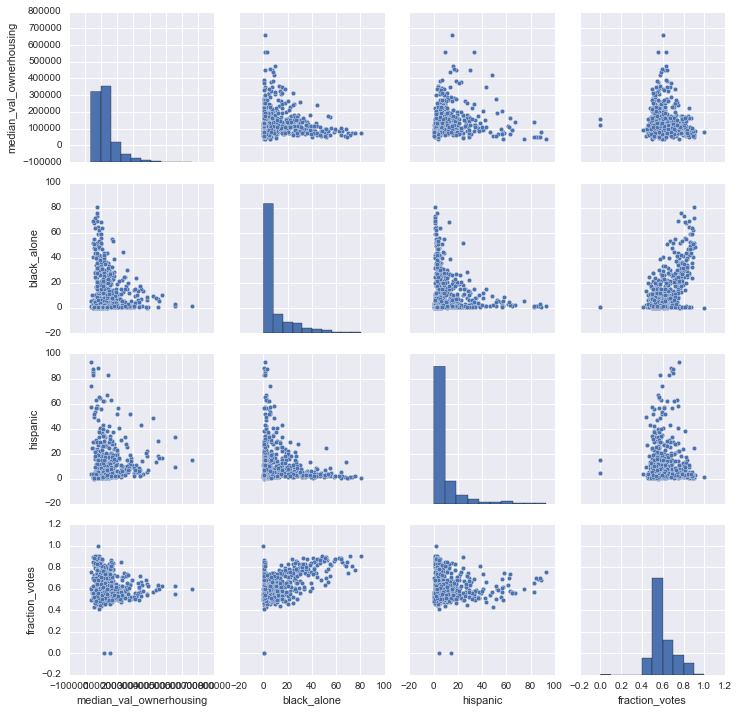

In [57]:
sns.pairplot(clinton[['median_val_ownerhousing', 'black_alone', 'hispanic', 'fraction_votes']])

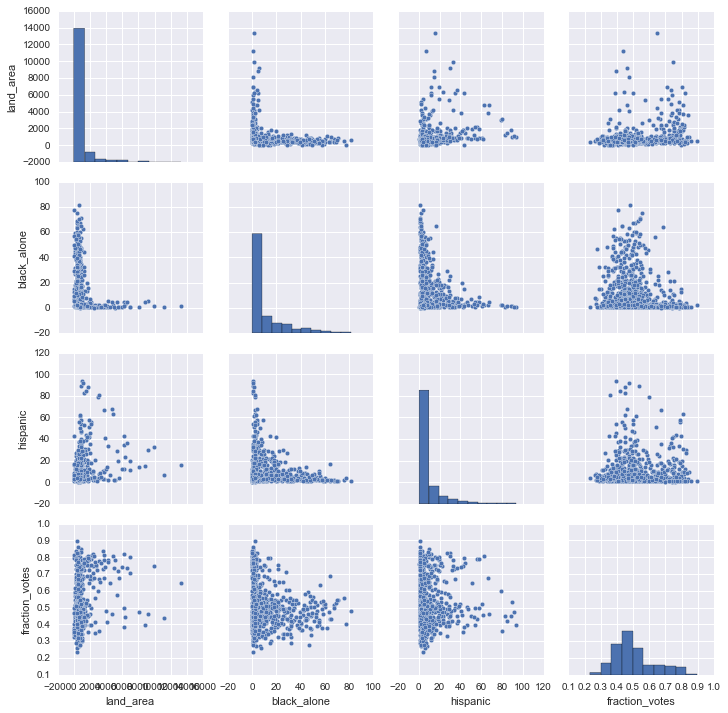

In [58]:
sns.pairplot(trump[['land_area', 'black_alone', 'hispanic', 'fraction_votes']])

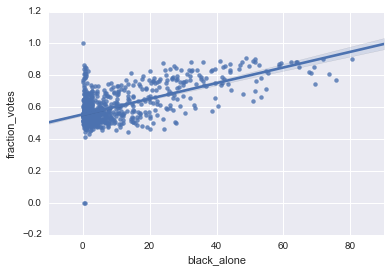

In [59]:
sns.regplot(x='black_alone', y='fraction_votes', data=clinton)

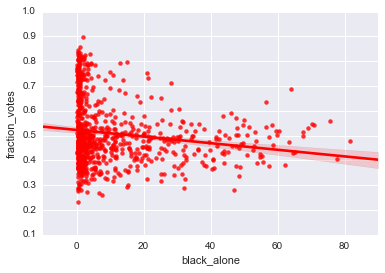

In [60]:
sns.regplot(x='black_alone', y='fraction_votes', data=trump, color='r')

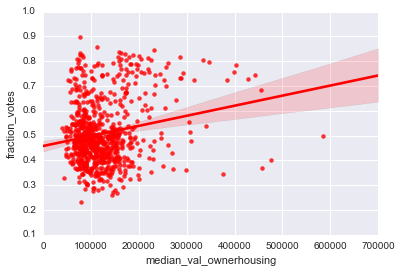

In [61]:
sns.regplot(x='median_val_ownerhousing', y='fraction_votes', data=trump, color='r')

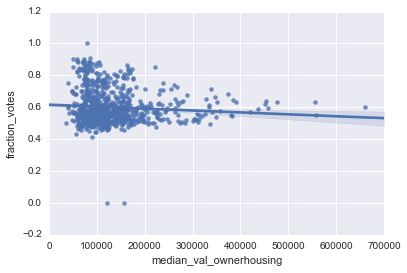

In [62]:
sns.regplot(x='median_val_ownerhousing', y='fraction_votes', data=clinton)

## Attempt at Logit Regression

In [63]:
import statsmodels.api as sm

numeric = general_tot.select_dtypes(exclude=['object']) # selecting only numeric types from dataset

X_col = numeric.columns.drop(['fraction_votes', 'votesleft', 'votesright', 'rank', 'win']) # dropping redundant values
y_col = 'win'


test_X = general_tot[['under_18_pct', 'black_alone', 'highschool']]
test_y = general_tot[y_col]


logit = sm.Logit(test_y, test_X)

# model.fit(train_X, train_y)
# train_yhat = model.predict(train_X)
# print 'train MSE: ', np.sqrt(metrics.mean_squared_error(train_y, train_yhat))

# test_yhat = model.predict(test_X)
# print 'test MSE: ', np.sqrt(metrics.mean_squared_error(test_y, test_yhat))

In [64]:
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.692929
         Iterations 3


In [65]:
print result.summary()

                           Logit Regression Results                           
Dep. Variable:                    win   No. Observations:                 5507
Model:                          Logit   Df Residuals:                     5504
Method:                           MLE   Df Model:                            2
Date:                Wed, 10 Aug 2016   Pseudo R-squ.:               0.0001260
Time:                        15:29:15   Log-Likelihood:                -3816.0
converged:                       True   LL-Null:                       -3816.4
                                        LLR p-value:                    0.6183
                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
under_18_pct    -0.0037      0.007     -0.555      0.579        -0.017     0.009
black_alone     -0.0010      0.002     -0.568      0.570        -0.005     0.002
highschool       0.0015      0.002      0.84

the logistic regression does not return significant results. likely a fitting error
above we need to create new column that converts count of votes to a fraction of votes column